In [100]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.float_format', '{:.3f}'.format)
# and numpy
np.set_printoptions(suppress=True, precision=5)

In [101]:
terr = pd.read_csv('final_data.csv')
terr.drop('Unnamed: 0',axis=1,inplace=True)

In [102]:
#other = pd.read_csv('LABED_dat.csv')

In [103]:
#data = pd.merge(terr,other[['eventid','label_3']],right_on='eventid' ,left_on='eventid',how='left')

In [104]:
data = terr

In [105]:
data = data[data['year']>=2000]

In [106]:
print(data.columns.to_list())

['att_Armed Assault', 'att_Assassination', 'att_Bombing/Explosion', 'att_Facility/Infrastructure Attack', 'att_Hijacking', 'att_Hostage Taking (Kidnapping)', 'att_Unarmed Assault', 'weap_Biological', 'weap_Chemical', 'weap_Explosives', 'weap_Fake Weapons', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Radiological', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Abortion Related', 'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_East 

In [107]:
rqmask = data['country_txt'] == 'Iraq'
smmask = data['country_txt'] == 'Somalia'
symask = data['country_txt'] == 'Syria'

# Combine the masks with an 'or' condition
mask_to_drop = rqmask | smmask | symask

# Use the negation of the combined mask to keep rows where the mask is False
data = data[~mask_to_drop]
#df.loc[rqmask,'warzone'] = 1
#df.loc[smmask,'warzone'] = 1
#df.loc[symask,'warzone'] = 1

In [108]:
df_filtered = data[data['gname'] != 'Unknown']

# Counting the number of attacks per organization
attacks_per_org = df_filtered['gname'].value_counts().sort_values(ascending=False)

# Converting to a format suitable for the Kneedle algorithm
# The Kneedle algorithm expects the data to be in a sorted order
x = range(1, len(attacks_per_org) + 1)
y = attacks_per_org.values

# Finding the elbow point
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow
# identify the most common orgs
most_common_orgs = attacks_per_org.index.to_list()[:elbow_point]

# Modify the df['terrorist.org'] column
# Check if each value is in the most_common_orgs list, otherwise replace it with 'other'
data['gname'] = data['gname'].apply(lambda org: org if org in most_common_orgs else 'other')

In [109]:
data= data.dropna(subset='nkill')

In [110]:
data['letal'] = data['nkill'].apply(lambda x:1 if x !=0 else 0)

In [111]:
data['letal']

57110     0
57111     0
57112     1
57113     0
57115     0
         ..
173448    0
173449    0
173450    0
173451    1
173452    1
Name: letal, Length: 86548, dtype: int64

In [112]:
"""
data['arm_mili'] = data['att_Armed Assault'] * data['targ_Military']
data['arm_poli'] = data['att_Armed Assault'] * data['targ_Police']
data['arm_citi'] = data['att_Armed Assault'] * data['targ_Private Citizens & Property']
data['sui_expl'] = data['suicide'] * data['weap_Explosives']
data['expl_asia'] = data['att_Bombing/Explosion'] * data['reg_Middle East & North Africa']
data['att_trasp'] = data['weap_Explosives'] * data['targ_Transportation']
data['warm_mili'] = data['weap_Firearms'] * data['targ_Military']
data['warm_poli'] = data['weap_Firearms'] * data['targ_Police']
data['warm_citi'] = data['weap_Firearms'] * data['targ_Private Citizens & Property']
"""

"\ndata['arm_mili'] = data['att_Armed Assault'] * data['targ_Military']\ndata['arm_poli'] = data['att_Armed Assault'] * data['targ_Police']\ndata['arm_citi'] = data['att_Armed Assault'] * data['targ_Private Citizens & Property']\ndata['sui_expl'] = data['suicide'] * data['weap_Explosives']\ndata['expl_asia'] = data['att_Bombing/Explosion'] * data['reg_Middle East & North Africa']\ndata['att_trasp'] = data['weap_Explosives'] * data['targ_Transportation']\ndata['warm_mili'] = data['weap_Firearms'] * data['targ_Military']\ndata['warm_poli'] = data['weap_Firearms'] * data['targ_Police']\ndata['warm_citi'] = data['weap_Firearms'] * data['targ_Private Citizens & Property']\n"

In [113]:
#dropss  = ['targ_Airports & Aircraft','targ_Educational Institution','att_Assassination','targ_Violent Political Party','weap_cbr','v2x_clphy','targ_Other','targ_Maritime','targ_Abortion Related','weap_Sabotage Equipment','targ_Government (General)','weap_Chemical','weap_Biological','weap_Radiological','v2x_ex_military','reg_South America','reg_Central Asia','targ_Telecommunication','weap_Other','reg_Central America & Caribbean','weap_Fake Weapons','reg_Southeast Asia','reg_East Asia']
#dropss += ['v2clsnlpct', 'Population', 'Net migration', 'Births from mothers aged 15 to 19 years', 'Population density','targ_Food or Water Supply']
#dropss = ['weap_Fake Weapons', 'weap_Melee', 'weap_Other', 'targ_Abortion Related', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'targ_NGO', 'targ_Other', 'reg_East Asia', 'reg_North America', 'reg_Sub-Saharan Africa', 'reg_Western Europe', 'INT_MISC', 'individual', 'multiple', 'success', 'v2cldiscw', 'v2clsnlpct', 'v2dlencmps', 'weap_cbr','att_Assassination', 'weap_Sabotage Equipment', 'targ_Airports & Aircraft', 'targ_Maritime', 'reg_Central Asia']

to_drop = ['success','country_txt','year','eventid','nkill','motive']# + dropss


In [114]:
df=data.drop(columns=to_drop)

In [115]:
print(df.columns.to_list())

['att_Armed Assault', 'att_Assassination', 'att_Bombing/Explosion', 'att_Facility/Infrastructure Attack', 'att_Hijacking', 'att_Hostage Taking (Kidnapping)', 'att_Unarmed Assault', 'weap_Biological', 'weap_Chemical', 'weap_Explosives', 'weap_Fake Weapons', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Radiological', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Abortion Related', 'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_East 

In [116]:
df

,att_Armed Assault,att_Assassination,att_Bombing/Explosion,att_Facility/Infrastructure Attack,att_Hijacking,att_Hostage Taking (Kidnapping),att_Unarmed Assault,weap_Biological,weap_Chemical,weap_Explosives,...,v2clacfree,v2dlencmps,v2elembcap,v2exhoshog,Population,Net migration,Births from mothers aged 15 to 19 years,Population density,GDP,letal
57110,1,0,0,0,0,0,0,0,0,0,...,1.725,0.854,0.650,1.000,1819148.000,5709.000,8375.000,2.210,12211898000.000,0
57111,0,0,0,0,0,1,0,0,0,0,...,1.725,0.854,0.650,1.000,1819148.000,5709.000,8375.000,2.210,12211898000.000,0
57112,1,0,0,0,0,0,0,0,0,0,...,1.090,1.222,1.499,0.000,1059633660.000,-149966.000,5222965.000,356.396,2724476700000.000,1
57113,0,0,1,0,0,0,0,0,0,1,...,1.235,1.243,0.772,1.000,1823291.000,-9176.000,2092.000,167.197,NaN,0
57115,0,0,1,0,0,0,0,0,0,1,...,1.090,1.222,1.499,0.000,1059633660.000,-149966.000,5222965.000,356.396,2724476700000.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173448,0,0,1,0,0,0,0,0,0,1,...,-1.790,-1.793,-0.704,0.000,32284044.000,-86100.000,95767.000,61.148,NaN,0
173449,0,0,0,1,0,0,0,0,0,0,...,1.330,1.234,0.871,0.000,29348626.000,306664.000,103669.000,199.405,110403750000.000,0
173450,0,0,0,1,0,0,0,0,0,0,...,2.098,2.162,2.669,0.000,83328990.000,334055.000,13881.000,239.066,4311087000000.000,0
173451,1,0,0,0,0,0,0,0,0,0,...,0.487,0.204,-0.091,1.000,38972236.000,166821.000,188016.000,60.022,76710640000.000,1


In [117]:
print(len(df))

86548


In [118]:
df = df.dropna(axis=0, how='any')
print(len(df))

80116


In [119]:
df

,att_Armed Assault,att_Assassination,att_Bombing/Explosion,att_Facility/Infrastructure Attack,att_Hijacking,att_Hostage Taking (Kidnapping),att_Unarmed Assault,weap_Biological,weap_Chemical,weap_Explosives,...,v2clacfree,v2dlencmps,v2elembcap,v2exhoshog,Population,Net migration,Births from mothers aged 15 to 19 years,Population density,GDP,letal
57110,1,0,0,0,0,0,0,0,0,0,...,1.725,0.854,0.650,1.000,1819148.000,5709.000,8375.000,2.210,12211898000.000,0
57111,0,0,0,0,0,1,0,0,0,0,...,1.725,0.854,0.650,1.000,1819148.000,5709.000,8375.000,2.210,12211898000.000,0
57112,1,0,0,0,0,0,0,0,0,0,...,1.090,1.222,1.499,0.000,1059633660.000,-149966.000,5222965.000,356.396,2724476700000.000,1
57115,0,0,1,0,0,0,0,0,0,1,...,1.090,1.222,1.499,0.000,1059633660.000,-149966.000,5222965.000,356.396,2724476700000.000,0
57117,0,0,1,0,0,0,0,0,0,1,...,0.169,-0.278,1.945,0.000,64113548.000,-77647.000,168550.000,83.307,976023060000.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173447,0,0,0,0,0,1,0,0,0,0,...,1.231,-1.135,-0.789,0.000,92853170.000,-1643.000,527519.000,40.958,96945316000.000,1
173449,0,0,0,1,0,0,0,0,0,0,...,1.330,1.234,0.871,0.000,29348626.000,306664.000,103669.000,199.405,110403750000.000,0
173450,0,0,0,1,0,0,0,0,0,0,...,2.098,2.162,2.669,0.000,83328990.000,334055.000,13881.000,239.066,4311087000000.000,0
173451,1,0,0,0,0,0,0,0,0,0,...,0.487,0.204,-0.091,1.000,38972236.000,166821.000,188016.000,60.022,76710640000.000,1


In [120]:
df['gname']

57110                                       other
57111                                       other
57112                                       other
57115     United Liberation Front of Assam (ULFA)
57117                                       other
                           ...                   
173447             Allied Democratic Forces (ADF)
173449                                      other
173450                                      other
173451                                      other
173452                                      other
Name: gname, Length: 80116, dtype: object

In [121]:
df = pd.get_dummies(df, columns=['gname'], drop_first=True,dtype=int)

In [122]:
#collls =  ['gname_Al-Qaida in the Arabian Peninsula (AQAP)','gname_Al-Shabaab','gname_Basque Fatherland and Freedom (ETA)','gname_Boko Haram','gname_Communist Party of India - Maoist (CPI-Maoist)','gname_Corsican National Liberation Front (FLNC)',"gname_Donetsk People's Republic",'gname_Fulani extremists','gname_Houthi extremists (Ansar Allah)','gname_Irish Republican Army (IRA)','gname_Khorasan Chapter of the Islamic State',"gname_Kurdistan Workers' Party (PKK)",'gname_Liberation Tigers of Tamil Eelam (LTTE)','gname_Maoists','gname_Muslim extremists','gname_National Liberation Army of Colombia (ELN)',"gname_New People's Army (NPA)",'gname_Palestinian Extremists','gname_Palestinians','gname_Revolutionary Armed Forces of Colombia (FARC)','gname_Separatists','gname_Shining Path (SL)','gname_Sikh Extremists','gname_Sinai Province of the Islamic State','gname_Taliban','gname_Tehrik-i-Taliban Pakistan (TTP)','gname_other']
#collls = ['gname_Sikh Extremists','reg_Central America & Caribbean', 'reg_Southeast Asia', 'gname_Al-Shabaab', 'gname_Basque Fatherland and Freedom (ETA)', 'gname_Irish Republican Army (IRA)', 'gname_National Liberation Army of Colombia (ELN)', 'gname_Palestinians', 'gname_Separatists', 'gname_other']
#collls = ['gname_Al-Shabaab', 'gname_Basque Fatherland and Freedom (ETA)', 'gname_Irish Republican Army (IRA)', 'gname_National Liberation Army of Colombia (ELN)', 'gname_Palestinians', 'gname_Separatists', 'gname_other']
#df = df.drop(columns=collls)

In [123]:
df

,att_Armed Assault,att_Assassination,att_Bombing/Explosion,att_Facility/Infrastructure Attack,att_Hijacking,att_Hostage Taking (Kidnapping),att_Unarmed Assault,weap_Biological,weap_Chemical,weap_Explosives,...,gname_National Liberation Army of Colombia (ELN),gname_New People's Army (NPA),gname_Palestinian Extremists,gname_Revolutionary Armed Forces of Colombia (FARC),gname_Separatists,gname_Sinai Province of the Islamic State,gname_Taliban,gname_Tehrik-i-Taliban Pakistan (TTP),gname_United Liberation Front of Assam (ULFA),gname_other
57110,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
57111,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
57112,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
57115,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
57117,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173447,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173449,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
173450,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
173451,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [124]:
# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()



In [125]:
X = df.drop(columns='letal')
Y = df['letal']


In [126]:
# Drop variables with 0 variability (no information) or high correlation (multicollinearity)

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X)
# Get the columns after variance thresholding
X_encoded_var_filtered = X.iloc[:, selector.get_support(indices=True)]

In [127]:
# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping


In [128]:
print(to_drop)
X = X_encoded_var_filtered.drop(columns=to_drop)

['weap_Explosives']


In [129]:

X=X.drop(columns=[ 'weap_Fake Weapons', 'weap_Radiological', 'targ_Business', 'targ_Educational Institution', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North America', 'reg_South America', 'reg_South Asia', 'reg_Southeast Asia', 'reg_Sub-Saharan Africa', 'vicinity', 'nperpcap', 'v2x_clphy', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Fulani extremists', "gname_Kurdistan Workers' Party (PKK)", 'gname_Maoists', 'gname_Muslim extremists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Taliban', 'gname_Tehrik-i-Taliban Pakistan (TTP)']
)

#X = X.drop(columns=[ 'weap_Blunt Object', 'weap_Explosive', 'weap_Other Gun Type', 'weap_Suffocation', 'weap_Unknown Weapon Type', 'weap_Vehicle', 'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Other', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North America', 'reg_South America', 'reg_Southeast Asia', 'reg_Sub-Saharan Africa', 'reg_Western Europe', 'individual', 'vicinity', 'claimed', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Kurdistan Workers' Party (PKK)", 'gname_Maoists', 'gname_Muslim extremists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Taliban', 'gname_Tehrik-i-Taliban Pakistan (TTP)'])

In [130]:
fieros = ['weap_Explosives', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'targ_Business', 'targ_Government (General)', 'targ_Private Citizens & Property', 'reg_East Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North America', 'reg_South America', 'reg_South Asia', 'reg_Southeast Asia', 'reg_Sub-Saharan Africa', 'reg_Western Europe', 'att3_Hostage Taking (Kidnapping)', 'weap2_Chemical', 'weap2_Explosives', 'weap2_Fake Weapons', 'weap2_Firearms', 'weap2_Incendiary', 'weap2_Melee', 'weap2_Other', 'weap2_Unknown', 'weap2_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'weap3_Explosives', 'weap3_Firearms', 'weap3_Incendiary', 'weap3_Melee', 'targ2_Business', 'targ2_Government (Diplomatic)', 'targ2_Government (General)', 'targ2_Maritime', 'targ2_Military', 'targ2_NGO', 'targ2_Police', 'targ2_Private Citizens & Property', 'targ2_Tourists', 'targ2_Transportation', 'targ3_Private Citizens & Property', 'n_weap', 'n_att', 'n_targ', 'v2x_clphy', 'v2x_rule', 'v2cldiscw', 'v2clacfree', 'v2elembcap', 'Population', 'Births from mothers aged 15 to 19 years', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Maoists', "gname_New People's Army (NPA)", 'gname_Taliban', 'gname_other']

In [131]:
#X=X.drop(columns=fieros)

In [132]:
X2=X

In [133]:
scaler.fit(X2)
X2 = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

In [134]:
"""
X2.to_csv('logi_dat.csv')
Y.to_csv('logi_Y.csv')
"""

"\nX2.to_csv('logi_dat.csv')\nY.to_csv('logi_Y.csv')\n"

In [135]:
test_size = 0.3
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
scaler.fit(X_test)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_with_intercept = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

X_train shape: (56081, 139), y_train shape: (56081,)
X_test shape: (24035, 139), y_test shape: (24035,)


In [136]:
""""

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each column
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


askks2 = vif_data['VIF']>=5
# Print VIF values"""


'"\n\nimport pandas as pd\nfrom statsmodels.stats.outliers_influence import variance_inflation_factor\n\n# Calculate VIF for each column\nvif_data = pd.DataFrame()\nvif_data["feature"] = X.columns\nvif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]\n\n\naskks2 = vif_data[\'VIF\']>=5\n# Print VIF values'

In [137]:
#print(vif_data.loc[askks2,'feature'].to_list())

In [138]:
# Fit the model 
model = sm.Logit(y_train, X_with_intercept).fit(maxiter=1000)


c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.471922
         Iterations: 1000


LinAlgError: Singular matrix

In [ ]:
print(model.summary())

NameError: name 'model' is not defined

In [ ]:
results_summary = pd.DataFrame({
    'params': model.params,
    'pvalues': model.pvalues
})

# Find the parameters where the p-value is greater than 0.05
high_pvalue_params = results_summary[results_summary['pvalues'] > 0.05].index.tolist()

print("Parameters with p-value above 0.05:", high_pvalue_params)

Parameters with p-value above 0.05: ['individual', 'v2cldiscw', 'v2clacfree']


In [ ]:
# Define the intercept and coefficient for suicide from your model
intercept = 0.2580
coef = 0.7179      
indi = 0.0782

# Calculate z for a suicide attack
z_su = intercept + coef * 1 

# Calculate the probability that the attack is lethal
prob_lethal = 1 / (1 + np.exp(-z_su))

print(f"Probability that a suicide attack is lethal: {prob_lethal:.2f}")


Probability that a suicide attack is lethal: 0.73


In [ ]:
simulations_df = pd.DataFrame(model.params)
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')
tresholdd=0.01

In [ ]:
mask=simulations_df<tresholdd

ggg=simulations_df[mask]

mask2 = ggg>-tresholdd

gg44=ggg[mask2]

In [ ]:
lista = gg44.dropna()
print(lista.index.to_list())

['individual']


In [ ]:
beta_mean = model.params
beta_cov = model.cov_params()

n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

simulated_betas_odds = np.exp(simulated_betas)

In [ ]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = X_with_intercept.columns

C:\Users\lucab\AppData\Local\Temp\ipykernel_15228\3004529438.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


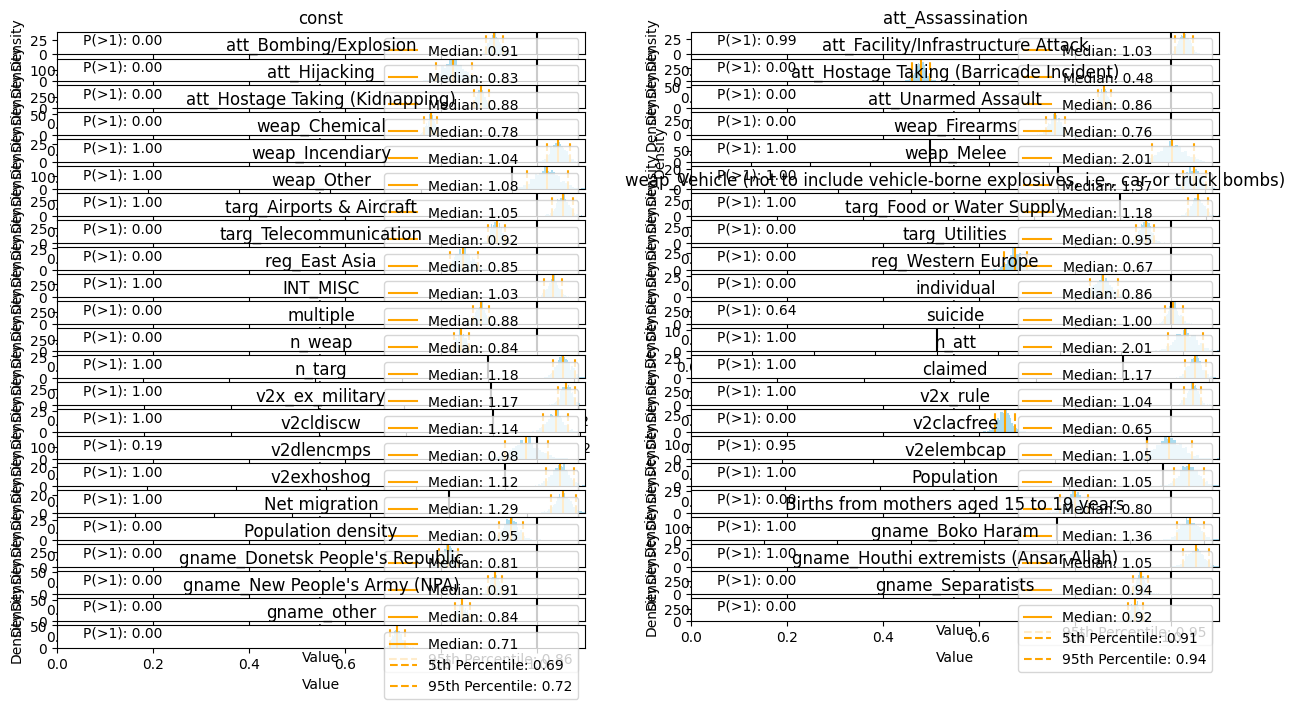

In [ ]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = X_with_intercept.columns

# Plot histograms of each coefficient
num_rows = (simulated_betas.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(simulated_betas.shape[1]):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_betas_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
list_aic = []


In [ ]:

aic = model.aic
list_aic.append((model,aic))
print("AIC:", aic)

AIC: 58100.29761727513


In [ ]:
print(list_aic)

[(<statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000017506C7E6C0>, 58100.29761727513)]


In [ ]:
predictions = model.predict(X_test_const)
binary_predictions = np.where(predictions > 0.5, 1, 0)

In [ ]:
y_test

145016    1
138407    1
164409    1
128764    0
150685    0
         ..
149730    1
121221    1
171336    1
178485    1
169085    1
Name: letal, Length: 25388, dtype: int64

In [ ]:
predictions

145016   0.790
138407   0.280
164409   0.552
128764   0.047
150685   0.285
          ... 
149730   0.804
121221   0.792
171336   0.473
178485   0.952
169085   0.747
Length: 25388, dtype: float64

Accuracy: 0.7642


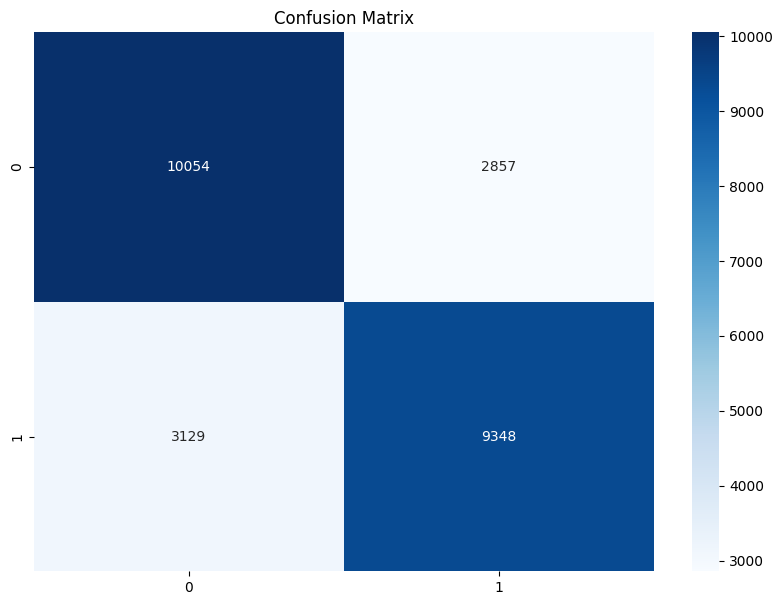

In [ ]:
# Calculate and print the accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
conf_matrix

array([[10054,  2857],
       [ 3129,  9348]], dtype=int64)

In [ ]:
score = brier_score_loss(y_test,predictions)
print("Brier score:", score)

Brier score: 0.16153746881525638
